### [kaggle] 중고차 가격 예측모델_선형회귀

#### 1. 회귀문제
* 선형회귀 (Linear Regression) 사용하여 가격 예측하기

#### 1) library import & data load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

In [2]:
data = pd.read_csv("train-data.csv")
data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


#### 2) 데이터 전처리

* null 결측치 제거

In [4]:
# null 결측치 제거
clean_data = data.copy()
print("before : ", clean_data.shape)    # before
# New_Price 많은 null -> 제거
# Unnamed: 0 정보 없음 -> 제거
clean_data.drop(columns = ["Unnamed: 0", "New_Price"], inplace = True)

clean_data.dropna("index", inplace = True)
clean_data = clean_data.reset_index(drop = True)
print("after : ", clean_data.shape)    # after

before :  (6019, 14)
after :  (5975, 12)


C:\Users\82106\AppData\Local\Temp/ipykernel_17992/710110484.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  clean_data.dropna("index", inplace = True)


* 차 종류 제거

In [5]:
# 차 종류 수
# 너무 많으면 overfitting 초래

len(np.unique(list(clean_data.Name)))

1855

In [6]:
# 차의 모델명 전처리
# Hyundai 등 브랜드만 남기기
clean_data['Name'].value_counts()

Mahindra XUV500 W8 2WD           49
Maruti Swift VDI                 45
Honda City 1.5 S MT              34
Maruti Swift Dzire VDI           34
Maruti Swift VDI BSIV            31
                                 ..
Ford Fiesta Titanium 1.5 TDCi     1
Mahindra Scorpio S10 AT 4WD       1
Hyundai i20 1.2 Era               1
Toyota Camry W4 (AT)              1
Mahindra Xylo D4 BSIV             1
Name: Name, Length: 1855, dtype: int64

In [7]:
names = list(clean_data.Name)
for i in range(len(names)) :
    names[i] = names[i].split(" ", 1)[0]   # 첫 번째 브랜드 명만!
clean_data.Name = names
clean_data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [8]:
len(clean_data['Name'].unique())    # 31 개로 차 모델명 종류 감소!

31

* 단위 제거, 수치만!

In [9]:
mileage = list(clean_data.Mileage)
engine = list(clean_data.Engine)
power = list(clean_data.Power)

for i in range(len(names)) :
    mileage[i] = mileage[i].split(" ", 1)[0]
    engine[i] = engine[i].split(" ", 1)[0]
    power[i] = power[i].split(" ", 1)[0]

clean_data.Mileage = mileage
clean_data.Engine = engine
clean_data.Power = power
clean_data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,26.6,998,58.16,5.0,1.75
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582,126.2,5.0,12.50
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.2,1199,88.7,5.0,4.50
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7.0,6.00
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2,1968,140.8,5.0,17.74


* 전처리한 데이터 확인

In [10]:
clean_data["Price"] = clean_data["Price"].astype(float)
clean_data["Kilometers_Driven"] = clean_data["Kilometers_Driven"].astype(float)
clean_data["Mileage"] = clean_data["Mileage"].astype(float)
clean_data["Engine"] = clean_data["Engine"].astype(float)

In [11]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5975 entries, 0 to 5974
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5975 non-null   object 
 1   Location           5975 non-null   object 
 2   Year               5975 non-null   int64  
 3   Kilometers_Driven  5975 non-null   float64
 4   Fuel_Type          5975 non-null   object 
 5   Transmission       5975 non-null   object 
 6   Owner_Type         5975 non-null   object 
 7   Mileage            5975 non-null   float64
 8   Engine             5975 non-null   float64
 9   Power              5975 non-null   object 
 10  Seats              5975 non-null   float64
 11  Price              5975 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 560.3+ KB


In [12]:
print(np.unique(list(clean_data.Name)))
print(np.unique(list(clean_data.Location)))
print(np.unique(list(clean_data.Fuel_Type)))
print(np.unique(list(clean_data.Transmission)))
print(np.unique(list(clean_data.Owner_Type)))

['Ambassador' 'Audi' 'BMW' 'Bentley' 'Chevrolet' 'Datsun' 'Fiat' 'Force'
 'Ford' 'Honda' 'Hyundai' 'ISUZU' 'Isuzu' 'Jaguar' 'Jeep' 'Lamborghini'
 'Land' 'Mahindra' 'Maruti' 'Mercedes-Benz' 'Mini' 'Mitsubishi' 'Nissan'
 'Porsche' 'Renault' 'Skoda' 'Smart' 'Tata' 'Toyota' 'Volkswagen' 'Volvo']
['Ahmedabad' 'Bangalore' 'Chennai' 'Coimbatore' 'Delhi' 'Hyderabad'
 'Jaipur' 'Kochi' 'Kolkata' 'Mumbai' 'Pune']
['CNG' 'Diesel' 'LPG' 'Petrol']
['Automatic' 'Manual']
['First' 'Fourth & Above' 'Second' 'Third']


In [13]:
np.unique(list(clean_data.Seats))

# seats 0 제거
clean_data = clean_data[clean_data.Seats != 0]
np.unique(list(clean_data.Seats))

array([ 2.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [14]:
clean_data.shape

(5974, 12)

In [15]:
len(clean_data.Power.unique())

371

In [16]:
np.unique(list(clean_data.Power))

array(['100', '100.6', '101', '102', '102.5', '102.53', '102.57', '103',
       '103.2', '103.25', '103.3', '103.5', '103.52', '103.6', '104',
       '104.68', '105', '105.5', '106', '107.2', '107.3', '108.4',
       '108.45', '108.49', '108.495', '108.5', '108.62', '110', '110.4',
       '110.5', '112', '112.2', '112.4', '113.98', '114', '114.4', '115',
       '116.3', '116.4', '116.6', '116.9', '117.3', '118', '118.3',
       '118.6', '120', '120.33', '120.7', '121.3', '121.36', '121.4',
       '122', '123.24', '123.37', '123.7', '125', '126.2', '126.24',
       '126.3', '126.32', '127', '130', '130.2', '130.3', '132', '134',
       '135.1', '136', '138', '138.02', '138.03', '138.08', '138.1',
       '139.01', '139.07', '140', '140.8', '141', '141.1', '142', '143',
       '144', '147.5', '147.51', '147.6', '147.8', '147.9', '148',
       '148.31', '149.92', '150', '152', '152.88', '153.86', '154', '155',
       '156', '157.7', '157.75', '157.8', '158', '158.2', '158.8', '160',
      

In [17]:
clean_data.Power.isnull().sum()

0

In [18]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5974 entries, 0 to 5974
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5974 non-null   object 
 1   Location           5974 non-null   object 
 2   Year               5974 non-null   int64  
 3   Kilometers_Driven  5974 non-null   float64
 4   Fuel_Type          5974 non-null   object 
 5   Transmission       5974 non-null   object 
 6   Owner_Type         5974 non-null   object 
 7   Mileage            5974 non-null   float64
 8   Engine             5974 non-null   float64
 9   Power              5974 non-null   object 
 10  Seats              5974 non-null   float64
 11  Price              5974 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 606.7+ KB


#### 3) 데이터 재정의

In [21]:
remove = list(clean_data["Power"])

In [22]:
idx = []
remove = list(clean_data["Power"])
for i in range(len(remove)) :
    if (remove[i] == 'null') :      # Power에 null 값 있는거 모아서 없애기!
        idx.append(i)
clean_data = clean_data.drop(idx)
clean_data = clean_data.reset_index(drop = True)

In [25]:
np.unique(clean_data["Power"])

array(['100', '100.6', '101', '102', '102.5', '102.53', '102.57', '103',
       '103.2', '103.25', '103.3', '103.5', '103.52', '103.6', '104',
       '104.68', '105', '105.5', '106', '107.2', '107.3', '108.4',
       '108.45', '108.49', '108.495', '108.5', '108.62', '110', '110.4',
       '110.5', '112', '112.2', '112.4', '113.98', '114', '114.4', '115',
       '116.3', '116.4', '116.6', '116.9', '117.3', '118', '118.3',
       '118.6', '120', '120.33', '120.7', '121.3', '121.36', '121.4',
       '122', '123.24', '123.37', '123.7', '125', '126.2', '126.24',
       '126.3', '126.32', '127', '130', '130.2', '130.3', '132', '134',
       '135.1', '136', '138', '138.02', '138.03', '138.08', '138.1',
       '139.01', '139.07', '140', '140.8', '141', '141.1', '142', '143',
       '144', '147.5', '147.51', '147.6', '147.8', '147.9', '148',
       '148.31', '149.92', '150', '152', '152.88', '153.86', '154', '155',
       '156', '157.7', '157.75', '157.8', '158', '158.2', '158.8', '160',
      

In [26]:
clean_data["Power"] = clean_data["Power"].astype(float)

In [27]:
clean_data.shape

(5844, 12)

* 카테고리별로 분류

In [28]:
clean_data["Year"] = pd.Categorical(clean_data["Year"])
clean_data["Seats"] = pd.Categorical(clean_data["Seats"])

# 접두사 놓기
clean_data = pd.get_dummies(clean_data, prefix_sep = "_", drop_first = True)
clean_data.head()

,Kilometers_Driven,Mileage,Engine,Power,Price,Name_Audi,Name_BMW,Name_Bentley,Name_Chevrolet,Name_Datsun,...,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Seats_4.0,Seats_5.0,Seats_6.0,Seats_7.0,Seats_8.0,Seats_9.0,Seats_10.0
0,72000.0,26.60,998.0,58.16,1.75,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,41000.0,19.67,1582.0,126.20,12.50,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,46000.0,18.20,1199.0,88.70,4.50,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,87000.0,20.77,1248.0,88.76,6.00,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,40670.0,15.20,1968.0,140.80,17.74,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [29]:
clean_data.shape

(5844, 79)

#### 4) 데이터 이상치 확인

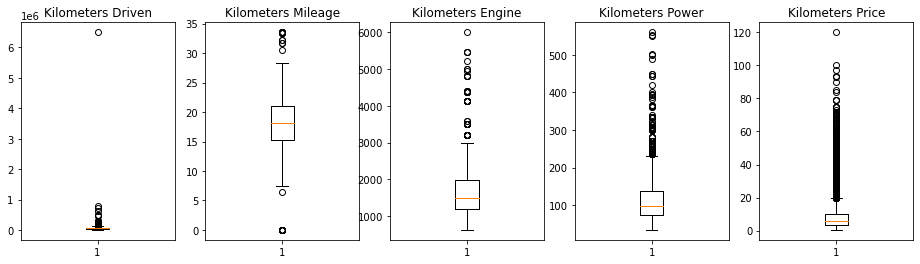

In [30]:
fig, ax = plt.subplots(1, 5, figsize = (16, 4))

ax[0].boxplot(list(clean_data.Kilometers_Driven))
ax[0].set_title("Kilometers Driven")

ax[1].boxplot(list(clean_data.Mileage))
ax[1].set_title("Kilometers Mileage")

ax[2].boxplot(list(clean_data.Engine))
ax[2].set_title("Kilometers Engine")

ax[3].boxplot(list(clean_data.Power))
ax[3].set_title("Kilometers Power")

ax[4].boxplot(list(clean_data.Price))
ax[4].set_title("Kilometers Price")

plt.show()    # kilometer Driven 완전 높은 값 검출

C:\Users\82106\anaconda3\envs\gani\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


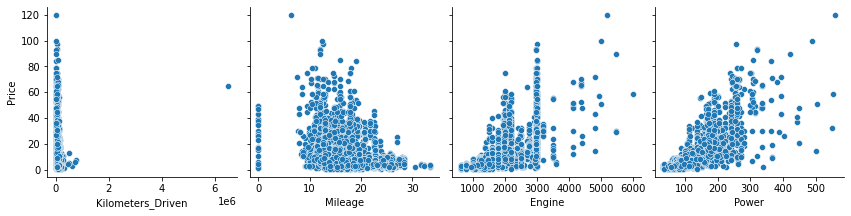

In [31]:
sns.pairplot(data = clean_data, x_vars = ["Kilometers_Driven", "Mileage", "Engine", "Power"], y_vars = "Price", size = 3)

* 아까 Kilometers_Driven 높은 애 제거

In [32]:
# 아까 Kilometers_Driven 높은 애 제거
idx = []
remove = list(clean_data["Kilometers_Driven"])

for i in range(len(remove)) :
    if ( remove[i] > 1000000 ) :
        idx.append(i)
clean_data = clean_data.drop(idx)
clean_data = clean_data.reset_index(drop = True)

* 높은 애 빼고 다시 비교

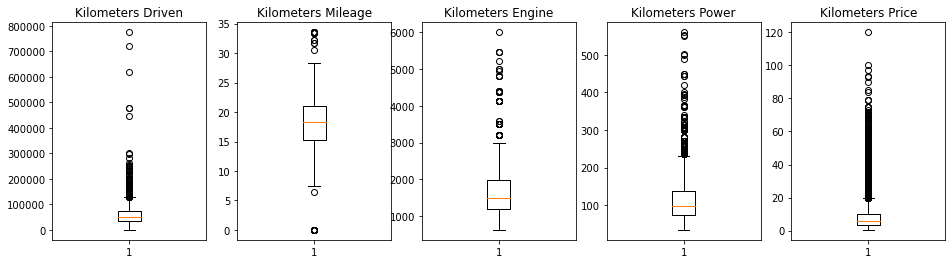

In [33]:
fig, ax = plt.subplots(1, 5, figsize = (16, 4))

ax[0].boxplot(list(clean_data.Kilometers_Driven))
ax[0].set_title("Kilometers Driven")

ax[1].boxplot(list(clean_data.Mileage))
ax[1].set_title("Kilometers Mileage")

ax[2].boxplot(list(clean_data.Engine))
ax[2].set_title("Kilometers Engine")

ax[3].boxplot(list(clean_data.Power))
ax[3].set_title("Kilometers Power")

ax[4].boxplot(list(clean_data.Price))
ax[4].set_title("Kilometers Price")

plt.show()    # kilometer Driven 완전 높은 값 검출

C:\Users\82106\anaconda3\envs\gani\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


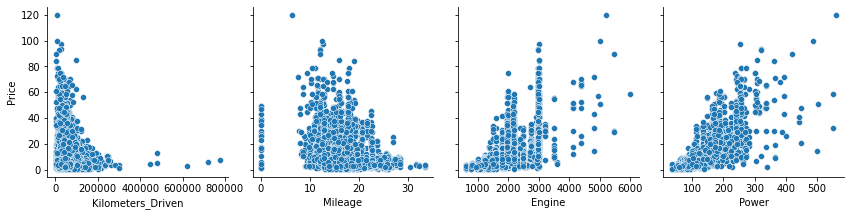

In [34]:
sns.pairplot(data = clean_data, x_vars = ["Kilometers_Driven", "Mileage", "Engine", "Power"], y_vars = "Price", size = 3)

#### 5) 데이터셋 생성

In [35]:
clean_data.shape

(5843, 79)

In [36]:
# train 데이터 생성

y = clean_data[["Price"]].to_numpy()
clean_Data = clean_data.drop(columns = ["Price"])

In [37]:
y.shape

(5843, 1)

In [38]:
x = clean_data.values
columns = clean_data.columns

In [39]:
x.shape

(5843, 79)

In [40]:
# Scale 하기 x 값만
scaler = preprocessing.MinMaxScaler()
tmp = scaler.fit_transform(x)
clean_data = pd.DataFrame(tmp)
clean_data.columns = columns

x = clean_data.to_numpy()

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state =42)

* " 삶과 우주, 그리고 모든 것에 대한 답은 42 입니다" 

In [42]:
columns

Index(['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Price', 'Name_Audi',
       'Name_BMW', 'Name_Bentley', 'Name_Chevrolet', 'Name_Datsun',
       'Name_Fiat', 'Name_Force', 'Name_Ford', 'Name_Honda', 'Name_Hyundai',
       'Name_ISUZU', 'Name_Isuzu', 'Name_Jaguar', 'Name_Jeep',
       'Name_Lamborghini', 'Name_Land', 'Name_Mahindra', 'Name_Maruti',
       'Name_Mercedes-Benz', 'Name_Mini', 'Name_Mitsubishi', 'Name_Nissan',
       'Name_Porsche', 'Name_Renault', 'Name_Skoda', 'Name_Tata',
       'Name_Toyota', 'Name_Volkswagen', 'Name_Volvo', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi',
       'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi',
       'Location_Kolkata', 'Location_Mumbai', 'Location_Pune', 'Year_1999',
       'Year_2000', 'Year_2001', 'Year_2002', 'Year_2003', 'Year_2004',
       'Year_2005', 'Year_2006', 'Year_2007', 'Year_2008', 'Year_2009',
       'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_20

#### 6) 모델링

In [43]:
lr = LinearRegression(fit_intercept = True, normalize = True, copy_X = True)

lr.fit(x_train, y_train)

LinearRegression(normalize=True)

#### 7) 결과 확인

In [44]:
# train data 정확도 측정
print("Train data\'s Accuracy : ", format(lr.score(x_train, y_train)))

Train data's Accuracy :  1.0


* 1 이 나올리가 없는데,,

In [45]:
y_predict = lr.predict(x_test)

In [46]:
# test data 정확도 측정
print("Test data\'s Accuracy : ", format(lr.score(x_test, y_test)))
print("Test data\'s Accuracy : ", format(r2_score(y_test, lr.predict(x_test))))

Test data's Accuracy :  0.9994238729822238
Test data's Accuracy :  0.9994238729822238


In [47]:
mean_absolute_error(y_test, y_predict)

0.00804930667509146